In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

%matplotlib inline
import load_month
import os
loader = load_month.TripsLoader()

In [2]:
%%time
# запускать только для подгтовки датасетов
# загрузка одного месяца для кластеризации
# (возьмите только те, которые были отобраны на второй неделе).
# Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
# список регионов для выбора возьмем с мая 2016. кластеризацию будем делать на апреле 2016

df = loader.load_month(2016, 5)
df.head()

CPU times: user 44.8 s, sys: 2.53 s, total: 47.3 s
Wall time: 45.1 s


In [3]:
regs = df.columns[df.mean()>=5].values
print(regs, regs.shape[0])

[1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174
 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224
 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441
 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068
 2069 2118 2119 2168] 102


In [4]:
%%time
# запускать только для подгтовки датасетов
# загрузка одного месяца для кластеризации
# кластеризацию будем делать на апреле 2016

df = loader.load_month(2016, 4)
df.head()

CPU times: user 44 s, sys: 2.38 s, total: 46.4 s
Wall time: 43.9 s


In [5]:
df[regs].head()
df = df[regs]
# прекрасно. начнем скалировать и кластеризировать

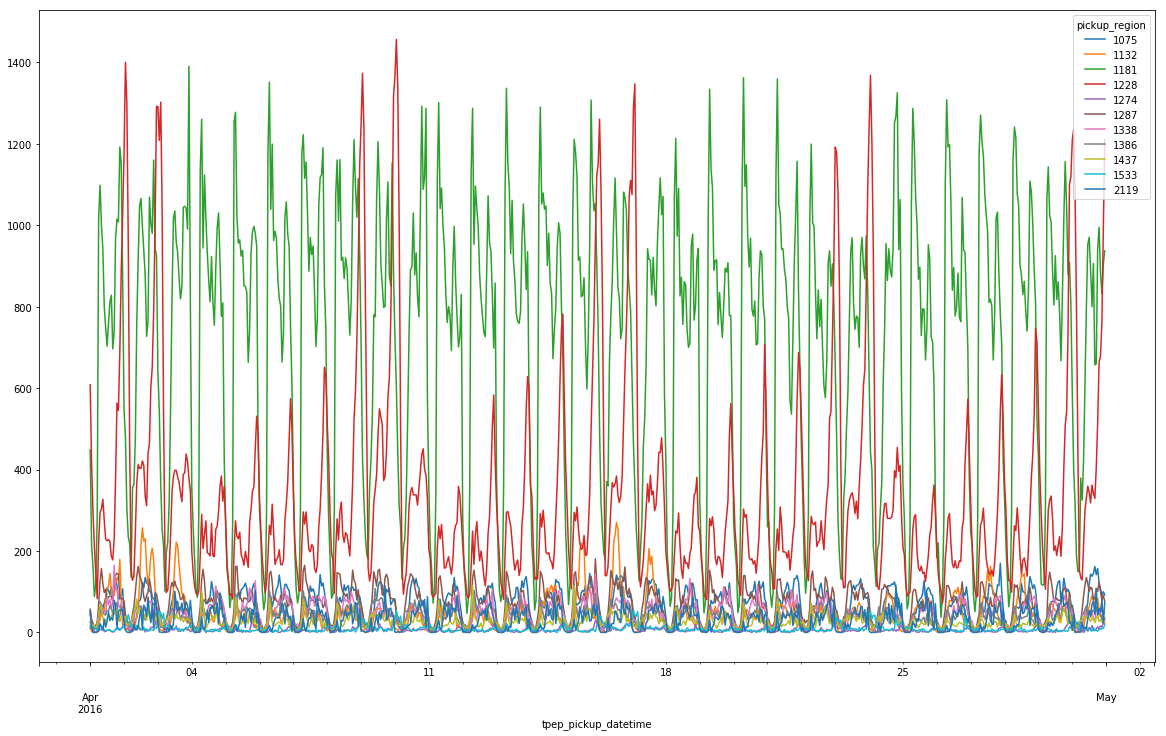

In [6]:
df[df.columns[::10]].plot(figsize=(20,12))

In [7]:
# прокластеризуем на данных за одну неделю с 4 по 10 апреля 2016
df = df[(df.index >= datetime(2016, 4, 4)) &
        (df.index < datetime(2016, 4, 11))]

In [9]:
# скалирование данных
X = StandardScaler().fit_transform(df.T)

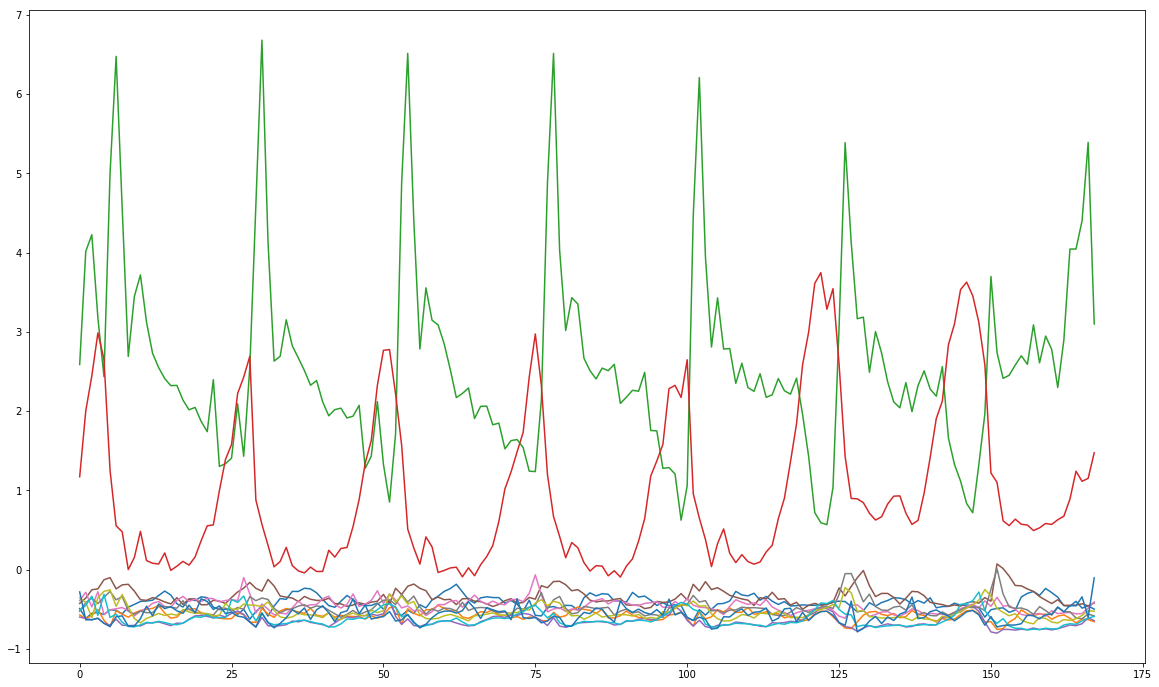

In [10]:
plt.figure(figsize=(20,12))
plt.plot(X[::10,:].T)
plt.show()

In [11]:
!pip install fastdtw

In [12]:
%%time
from fastdtw import fastdtw
import scipy.spatial.distance as ssd
dist = ssd.pdist(X, lambda x1, x2: fastdtw(x1, x2, dist=ssd.euclidean)[0])
matr = ssd.squareform(dist)

CPU times: user 4min 11s, sys: 215 ms, total: 4min 11s
Wall time: 4min 11s


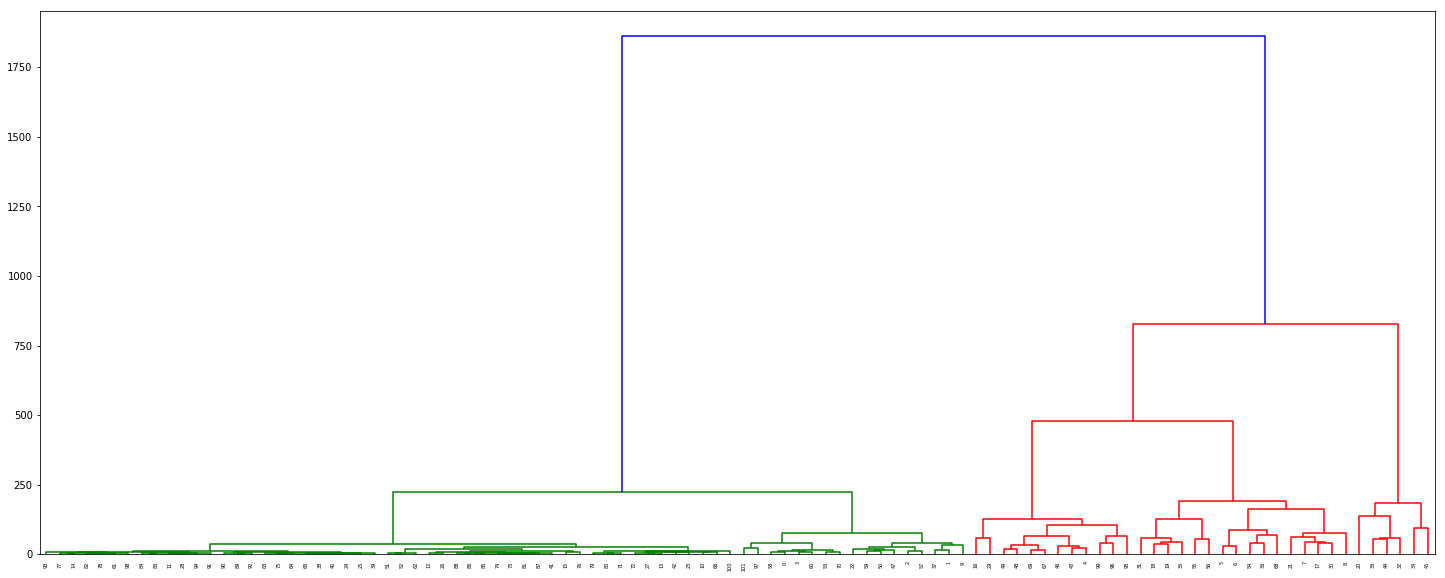

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, maxinconsts

Z = linkage(dist, 'ward', optimal_ordering=True)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [14]:
k = 10
clusters = fcluster(Z, k, criterion='maxclust') - 1
print(clusters)
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)), counts.max())

[1 1 1 1 2 5 5 6 6 1 0 0 0 0 0 0 2 6 3 3 8 6 1 0 0 0 0 0 0 2 6 3 7 7 9 3 5
 1 0 0 0 0 0 2 7 9 2 1 2 2 1 0 0 1 5 4 4 1 1 1 1 0 0 0 0 0 0 2 5 2 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 0 2 0 1]
{0: 51, 1: 17, 2: 12, 3: 4, 4: 2, 5: 5, 6: 5, 7: 3, 8: 1, 9: 2} 51


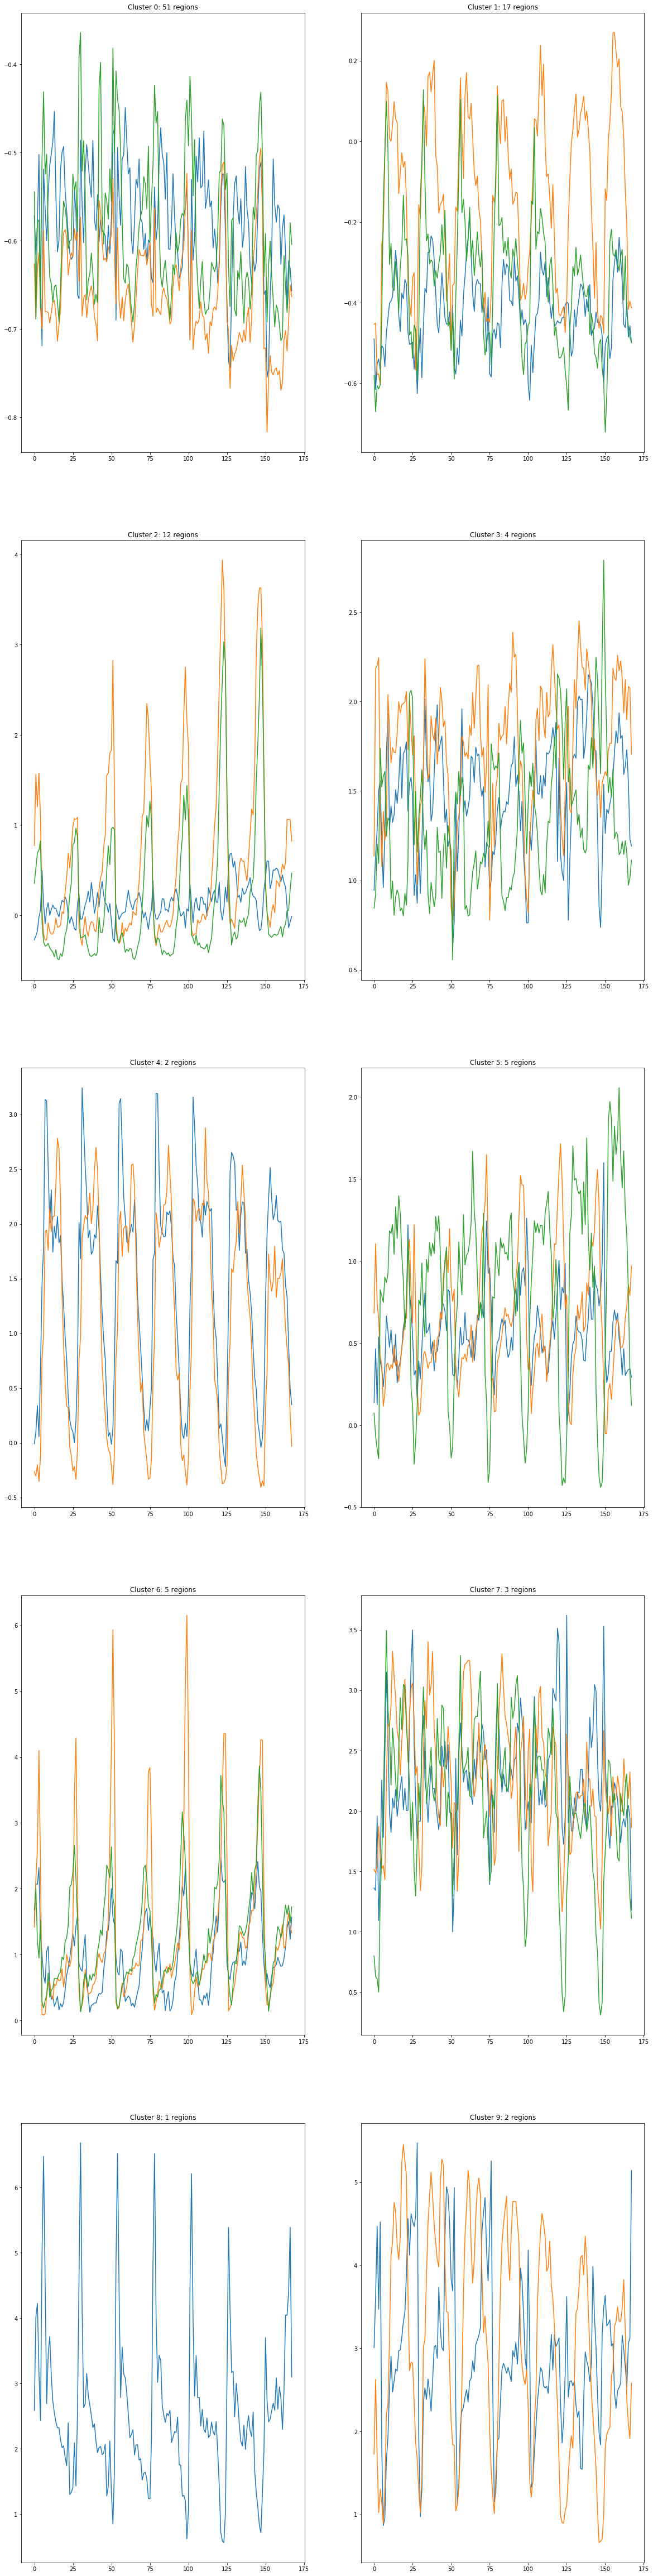

In [49]:
fig, axes = plt.subplots(k // 2, 2, figsize=(20,84))
for i in range(k):
    #print(i//2, i%2)
    ax = axes[i//2, i%2]
    ax.set_title("Cluster %d: %d regions"%(i, counts[i]))
    Xc = X[clusters==i]
    ax.plot(Xc.T[:,:3])
    #df[df.columns[clusters == i][:5]].plot(ax=ax)

plt.show()
    

In [16]:
# будем считать кластеризацию успешной
# кластеризация временных рядов тема сложная и подходит для отдельного курса, простой метод, считающийся бейзлайном данной темы
# выдает весьма странные в некоторых кластерах результаты, посмотрим как дальше будут вести себя модели для данных кластеров
# у нас есть кластера clusters, регионы regs.
# загрузим данные с июня 2015, подберем для каждого кластера регрессионную модель

In [17]:
%%time
# единовременная загрузка данных
folder = 'zip/'
files = [folder + x for x in os.listdir(folder) if x.endswith("csv.zip")]
files.sort()
files.remove(folder + 'yellow_tripdata_2016-06.csv.zip')
files.remove(folder + 'yellow_tripdata_2016-05.csv.zip')
pprint(files)

df = None
df = pd.concat((loader.load_month(file_name=f)[regs] for f in files[-11:]))

['zip/yellow_tripdata_2015-01.csv.zip',
 'zip/yellow_tripdata_2015-02.csv.zip',
 'zip/yellow_tripdata_2015-03.csv.zip',
 'zip/yellow_tripdata_2015-04.csv.zip',
 'zip/yellow_tripdata_2015-05.csv.zip',
 'zip/yellow_tripdata_2015-06.csv.zip',
 'zip/yellow_tripdata_2015-07.csv.zip',
 'zip/yellow_tripdata_2015-08.csv.zip',
 'zip/yellow_tripdata_2015-09.csv.zip',
 'zip/yellow_tripdata_2015-10.csv.zip',
 'zip/yellow_tripdata_2015-11.csv.zip',
 'zip/yellow_tripdata_2015-12.csv.zip',
 'zip/yellow_tripdata_2016-01.csv.zip',
 'zip/yellow_tripdata_2016-02.csv.zip',
 'zip/yellow_tripdata_2016-03.csv.zip',
 'zip/yellow_tripdata_2016-04.csv.zip']
CPU times: user 8min 19s, sys: 38.2 s, total: 8min 57s
Wall time: 8min 53s


In [18]:
df.to_csv('data/ytd_may15.csv', sep=';', header=True)

In [2]:
# загружаем списки кластеров и регионов, чтобы не грузить файлы каждый раз
clusters = np.array([1, 1, 1, 1, 2, 5, 5, 6, 6, 1, 0, 0, 0, 0, 0, 0, 2, 6, 3, 3, 8, 6, 1, 0, 0, 0, 0, 0, 0, 2, 6, 3,
                     7, 7, 9, 3, 5, 1, 0, 0, 0, 0, 0, 2, 7, 9, 2, 1, 2, 2, 1, 0, 0, 1, 5, 4, 4, 1, 1, 1, 1, 0, 0, 0,
                     0, 0, 0, 2, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
                     2, 1, 0, 2, 0, 1])
regs = np.array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1172, 1173, 1174, 1175, 1176, 
                 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229,
                 1230, 1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280, 1281, 1282, 1283, 1284,
                 1285, 1286, 1287, 1326, 1327, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377,
                 1378, 1380, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431, 1434, 1435, 1436,
                 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483, 1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734,
                 1783, 2068, 2069, 2118, 2119, 2168])

In [3]:
np.savetxt('data/clusters.txt', clusters, delimiter=',', fmt='%d')
np.savetxt('data/regs.txt', regs, delimiter=',', fmt='%d')

In [3]:
l_parse_dates = [u'tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']

df = pd.read_csv('data/ytd_may15.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,40,32,7,17,60,129,153,271,294,70,...,8,17,10,639,437,230,15,271,90,123
2015-06-01 01:00:00,17,20,5,13,38,90,111,163,246,28,...,6,7,22,547,490,212,21,237,124,119
2015-06-01 02:00:00,5,5,0,8,25,47,97,139,207,25,...,6,11,10,234,215,95,69,253,105,112
2015-06-01 03:00:00,5,6,0,6,27,26,68,77,208,29,...,13,0,2,84,10,17,6,78,3,94
2015-06-01 04:00:00,8,16,2,6,21,39,53,81,109,8,...,20,1,0,9,4,14,5,62,1,1


In [4]:
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,40,32,7,17,60,129,153,271,294,70,...,8,17,10,639,437,230,15,271,90,123
2015-06-01 01:00:00,17,20,5,13,38,90,111,163,246,28,...,6,7,22,547,490,212,21,237,124,119
2015-06-01 02:00:00,5,5,0,8,25,47,97,139,207,25,...,6,11,10,234,215,95,69,253,105,112
2015-06-01 03:00:00,5,6,0,6,27,26,68,77,208,29,...,13,0,2,84,10,17,6,78,3,94
2015-06-01 04:00:00,8,16,2,6,21,39,53,81,109,8,...,20,1,0,9,4,14,5,62,1,1


In [5]:
df.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-30 19:00:00,121,209,145,101,345,445,519,724,817,244,...,1,0,5,152,83,140,5,158,59,84
2016-04-30 20:00:00,107,208,99,107,290,411,543,733,840,210,...,2,0,2,141,41,119,11,232,50,120
2016-04-30 21:00:00,91,155,108,115,318,463,600,875,831,152,...,2,0,2,190,67,129,16,158,81,117
2016-04-30 22:00:00,100,97,85,100,217,421,697,955,909,203,...,1,0,2,230,80,132,21,198,23,93
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39


In [7]:
# введем t для настройки моделей
t = df.index - datetime(2015, 6, 1, 0, 0, 0)
t = t.days*24 + t.seconds // 3600
df['t'] = t
print(t)

# function
def get_t(dt_index):
    t = dt_index - datetime(2015, 6, 1, 0, 0, 0)
    t = t.days*24 + t.seconds // 3600
    return t

df['t'] = get_t(df.index)
print(t)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039],
           dtype='int64', name='tpep_pickup_datetime', length=8040)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039],
           dtype='int64', name='tpep_pickup_datetime', length=8040)


In [8]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[df.columns[:regs.shape[0]]].values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
df_scaled.shape

(8040, 102)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

cv_shuffle = ShuffleSplit(5, 0.2)
# массив регрессионных моделей
gb_models = []

k_list = [1, 5, 7 , 11, 13]  # коэфиценты взяты с третьей недели
# учет праздников с плавающими датами
import holidays #каникулы pip install holidays
hol = holidays.US(state='NY', years=range(2015, 2020))
tkd = []
for date, name in hol.items():
    if name in ('Thanksgiving', 'Memorial Day', 'Labor Day'):
        tkd.append(date)
tkd.sort()
#pprint(tkd)


In [11]:
#  функция получения массива признаков X
def get_X(df):
    t = df.t.values * np.pi / 168 * 2
    l = []
    for k in k_list:
        l.append(np.sin(t * k))
        l.append(np.cos(t * k))


    # прирост в полпроцента и смягчение выбросов даст учет праздников
    # праздники 4 июля, рождество, день памяти повышенный спрос
    l.append([1 if (x.month == 7 and x.day == 4) \
              or (x.month == 12 and x.day in (24, 25, 26, 31)) \
              or (x.month == 1 and x.day == 1 and x.hour >= 8) \
              or (x.month == 5 and x.day >= 22 and x.date in tkd) \
              or (x.month == 9 and x.day <= 10 and x.date in tkd) \
              else 0 for x in df.index])
    # в первые два часа после хелоуина меньше спрос и первые 3 часа нового года и в день благодарения
    l.append([1 if (x.month == 1 and x.day == 1 and x.hour <= 4) \
              or (x.month == 11 and x.day == 1 and x.hour < 3)
              or (x.month == 11 and x.day >= 22 and x.date in tkd and x.hour < 15 and x.hour > 7)
              else 0 for x in df.index])
    # 23 января была сильная метель. допустим мы можем получать сводку от метеорологов для учета данного обстоятельства
    # плюс мы уберем сильный выброс
    l.append([1 if (x.year == 2016 and x.month == 1 and x.day == 23 and x.hour >=10) \
              or (x.year == 2016 and x.month == 1 and x.day == 24 and x.hour <=12)
              else 0 for x in df.index])

    for d in range(7):
        l.append([1 if x.weekday() == d else 0 for x in df.index])

    t = np.arange(df.shape[0]) * np.pi / 8760 * 2
    l.append(np.sin(t))
    l.append(np.cos(t))
    l.append(np.sin(t * 2))
    l.append(np.cos(t * 2))
    X = np.array(l).T
    return X

In [13]:
from random import randint
model = GradientBoostingRegressor()
X = get_X(df)
gb_models = []
Y_cl = [] # стандартизированные прогнозы кластеров
i_cl = [] # выбранный ряд в кластере для обучения регрессии


for cl in range(10):
    cols = clusters==cl
    cl_len = cols.sum()
    r = randint(0, cl_len - 1) #  рандомный ряд из кластера
    i_cl.append(r)
    Y = df_scaled[:, cols]
    Y_cl.append(Y)
    Yt = Y[:, r]
    scores = cross_validate(model, X, Yt, cv=cv_shuffle)
    print('-'*40)
    print('Cluster: %d'%cl)
    print('\tcv scores on sample %d'%r, scores['test_score'], scores['test_score'].mean())
    gb_models.append(GradientBoostingRegressor())
    gb_models[-1].fit(X, Yt)
    print('\tmodel score: "%.3f'%gb_models[-1].score(X, Yt))
    cl_scores = np.array([gb_models[-1].score(X, Y[:, i]) for i in range(cl_len)])
    print("\tother scores: ",
          "(mean:%.3f) "%cl_scores.mean(),
          "(std:%.3f) "%cl_scores.std(),
          " ".join(["%.3f"%a for a in cl_scores]))
    


----------------------------------------
Cluster: 0
	cv scores on sample 2 [0.69005896 0.7425622  0.71720594 0.73935365 0.71137129] 0.7201104094697286
	model score: "0.746
	other scores:  (mean:0.020)  (std:0.329)  -0.651 0.561 0.746 0.623 0.354 -0.095 -0.067 0.048 0.043 0.128 0.271 0.235 0.021 -0.146 0.072 0.089 0.169 -0.157 -0.164 -0.033 -0.246 -0.144 -0.153 -0.270 -0.713 0.338 0.116 0.234 0.414 -0.268 -0.080 0.006 -0.014 0.173 0.197 0.327 0.255 0.239 0.041 0.258 0.254 0.351 0.408 -0.252 -0.107 0.242 -0.301 -0.686 -0.468 -0.509 -0.673
----------------------------------------
Cluster: 1
	cv scores on sample 7 [0.87879393 0.86313399 0.88579305 0.88922502 0.87203499] 0.8777961964106374
	model score: "0.889
	other scores:  (mean:0.469)  (std:0.275)  0.682 0.831 0.565 0.408 0.123 0.044 0.804 0.889 0.521 0.331 0.641 0.698 0.415 0.421 0.390 0.350 -0.149
----------------------------------------
Cluster: 2
	cv scores on sample 2 [0.92732752 0.92816146 0.93049505 0.93899527 0.91956005] 0.92890

In [12]:
# 0 - мусорный кластерб 1-й немногим лучше как и 2-й, возможно их можно разбить еще на кластеры, но тогда не хватит мощностей 
# для просчета. 3,4,7,8,9 кластеры - неплохи, 5, 6 имеет выбросы
# кластеризация временных рядов сложная вещь, в данном случае, регрессионная модель дает неплохие результаты для 5 кластеров
# охватывающих 12 моделей, также покрывается два кластера 5 и 6 не полностью, но добавляет к охвату еще 7 моделей.
# возможно имеет смысл использовать регрессию только для удачных кластеров, а остальные кластеры целиком кормить SARIMAX без exog

In [19]:
# я не буду пересчитывать параметры для каждого кластера, а возьму оптимальные с прошлой недели
# order= (15, 1, 3), seasonal_order=(1, 1, 1, 24)
# вычислительные ресурсы опять-таки конечны
# в конце концов каждая модель описывает спрос на такси в одном и том же городе, + (15, 1, 3) достаточно глубокая модель
# (1,1,1,24) - учитывает дневуню сезонность и не требует больших вычислительных ресурсов
# учитывая "успешность" первых трех кластеров, результат мне заранее не нравится
# для улучшения реузльтата имеет смысл для каждого ряда обучать модель, благо  градиентный бустинг на годовых данных работает
# весьма быстро, но в данном задании такого вопроса не стоит
# в данном задании я откажусь от использования регрессора и буду считать только SARIMAX

In [133]:
%%time
import statsmodels.api as sm
from sklearn.metrics import r2_score
arima_models_params = []
start = 24 + 1
end = start + 168*5

for cl in range(10):
    Y = Y_cl[cl]
    cl_len = Y.shape[1]
    i = i_cl[cl]
    endog = Y[:, i][-168*6:]
    
    model=sm.tsa.statespace.SARIMAX(endog,
                                    order= (15, 1, 3),
                                    seasonal_order=(1, 1, 1, 24),
                                    enforce_invertibility=False,
                                    enforce_stationarity=False,
                                   ).fit(disp=-1)
    arima_models_params.append(model)
    print('-'*40)
    print('Cluster: %d'%cl, "arima r2 score: %.3f"%r2_score(endog[start:end], model.fittedvalues[start:end]))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


----------------------------------------
Cluster: 0 arima r2 score: 0.674
----------------------------------------
Cluster: 1 arima r2 score: 0.897
----------------------------------------
Cluster: 2 arima r2 score: 0.914
----------------------------------------
Cluster: 3 arima r2 score: 0.928
----------------------------------------
Cluster: 4 arima r2 score: 0.936
----------------------------------------
Cluster: 5 arima r2 score: 0.920
----------------------------------------
Cluster: 6 arima r2 score: 0.863
----------------------------------------
Cluster: 7 arima r2 score: 0.942
----------------------------------------
Cluster: 8 arima r2 score: 0.878
----------------------------------------
Cluster: 9 arima r2 score: 0.967
CPU times: user 27min 36s, sys: 6.52 s, total: 27min 42s
Wall time: 14min 7s


In [127]:
index=pd.DatetimeIndex(freq='1H', start = '2016-04-30 23:00:00', end='2016-05-31 17:00:00')
df_mays = pd.DataFrame(index=index)
df_mays['t'] = get_t(df_mays.index)
X_may = get_X(df_mays)

In [128]:
Y_reg_pred_may = []
time_len = X_may.shape[0]
for cl in range(10):
    cl_len = Y_cl[cl].shape[1]
    if gb_models[cl] is None:
        Y = np.zeros((time_len, cl_len))
        Y_reg_pred_may.append(Y)
    else:
        preds = gb_models[cl].predict(X_may)
        Y = np.array([np.repeat(preds, cl_len)]).reshape(time_len, -1)
        Y_reg_pred_may.append(Y)

for Y in Y_reg_pred_may:
    print(Y.shape)

(739, 51)
(739, 17)
(739, 12)
(739, 4)
(739, 2)
(739, 5)
(739, 5)
(739, 3)
(739, 1)
(739, 2)


In [129]:
%%time
df_may_true = pd.concat([
    loader.load_month(2016, 4)[regs]['2016-04-30 23:00:00':],
    loader.load_month(2016, 5)[regs]])

/anaconda3/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


CPU times: user 1min 29s, sys: 6.39 s, total: 1min 36s
Wall time: 1min 31s


In [130]:
df_may_true.head()

pickup_region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39
2016-05-01 00:00:00,71,64,52,81,259,535,691,994,1100,193,...,7,0,3,60,94,42,7,146,4,85
2016-05-01 01:00:00,37,39,13,38,121,465,686,1024,1292,310,...,7,0,0,3,9,21,7,50,0,35
2016-05-01 02:00:00,10,46,8,34,86,410,621,843,1368,327,...,12,0,0,1,2,2,0,7,0,0
2016-05-01 03:00:00,14,25,6,23,59,241,355,591,1250,342,...,15,0,1,0,0,0,0,13,0,0


In [131]:
import warnings
order=(15, 1, 3)
seasonal_order=(1, 1, 1, 24)
Q = 0

In [134]:
%%time
warnings.filterwarnings('ignore')

for cl in range(10):
    cls = regs[clusters==cl]
    model = arima_models_params[cl] 
    for region in cls:
        data = df[str(region)]['2016-04-01 00:00:00':]
        df_true = df_may_true[region]
        model_fitted = sm.tsa.statespace.SARIMAX(data,
                                                 order=order,
                                                 seasonal_order=seasonal_order
                                                ).filter(model.params)
        for time in df_mays.index:
            preds = model_fitted.predict(time+1, time+6, dynamic=True).values
            #print(preds)
            trues = df_true[time+1:time+6].values
            #print(trues)
            Q += np.abs((preds - trues)).sum()
            #print(Q)
        
    
warnings.filterwarnings('default')    

CPU times: user 3h 50min 36s, sys: 45min 53s, total: 4h 36min 29s
Wall time: 2h 19min


In [135]:
Q = Q / (102 * 739 * 6)
print(Q)

60.36610856860727


In [136]:
# как же долго это все считается
# повторим тоже самое для июня.
# реальные данные нам не нужны, только timerange
# для ускорения обучим модель на данных df_may_true (1 месяц май)
# 

In [138]:
header = 'id,y'
timerange = pd.DatetimeIndex(freq='1H', start = '2016-05-31 23:00:00', end='2016-06-30 17:00:00')
# 1075_2016-05-31_23_1,0
def get_date_str(time):
    return str(time.date()) + '_' + str(time.hour) + '_'

print(get_date_str(timerange[0]))

2016-05-31_23_


In [159]:
%%time
warnings.filterwarnings('ignore')
preds = []
for ind, region in enumerate(regs):
    cl = clusters[ind]
    model = arima_models_params[cl]
    data = df_may_true[region]['2016-05-01 00:00:00':]
    reg_str = str(region) + '_'
    model_fitted = sm.tsa.statespace.SARIMAX(data,
                                             order=order,
                                             seasonal_order=seasonal_order
                                            ).filter(model.params)
    for time in timerange:
        for ind, val in enumerate(model_fitted.predict(time+1, time+6, dynamic=True).values, 1):
            preds.append(reg_str + get_date_str(time) + str(ind) + ',%.0f'%abs(val))
    

warnings.filterwarnings('default')
print(len(preds))

437580
CPU times: user 3h 29min 30s, sys: 24min 30s, total: 3h 54min 1s
Wall time: 1h 58min 25s


In [160]:
with open('data/output-june.csv', 'w', newline='\n') as f:
    f.write(header + '\n')
    for row in preds:
        f.write(row)
        f.write('\n')


In [156]:
!head data/output-june.csv

id,y
1075_2016-05-31_23_1,28
1075_2016-05-31_23_2,14
1075_2016-05-31_23_3,7
1075_2016-05-31_23_4,0
1075_2016-05-31_23_5,0
1075_2016-05-31_23_6,8
1075_2016-06-01_0_1,14
1075_2016-06-01_0_2,7
1075_2016-06-01_0_3,0


In [ ]:
link
https://www.kaggle.com/submissions/7950959/7950959.zip
Leaderboard:
    93
    Eugene K
    48.55448